## Classfication of Default of Payment in the following month 
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
### Problem Statement
> Develop a Classification Model to Predict if a customer will default on their payment the following month


## Evaluation Metrics
#### Choosing our Metric
The main priority in this problem is to ensure that our model can accurately identify on whether customers will default on their payment, which is more important than identifying ones that do not. Therefore, we want to use a classification metric that puts more emphasis on minimizing false negatives, as these are more costly than false positives.So we use Recall
##### Recall

$$
   Recall = \frac{True Positive}{True Positive + False Negatives}
$$

Recall quantifies the model's ability to avoid false negatives, i.e., instances that are actually positive but are classified as negative.For example, a customer defaulting their payment but predidcted to not default on their payment.
> A high recall value indicates that the model has a low rate of false negatives, meaning it is effective at capturing positive instances. On the other hand, a low recall value indicates that the model has a high rate of false negatives, indicating that it is missing a significant number of positive instances.

In [1]:
#comment out if already installed
# ! pip install imblearn

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from warnings import filterwarnings 

from sklearn.model_selection import train_test_split, cross_validate,KFold,GridSearchCV,cross_val_score,learning_curve,validation_curve
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import BorderlineSMOTE,RandomOverSampler, SMOTENC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer,confusion_matrix,classification_report
from sklearn.preprocessing import RobustScaler,OrdinalEncoder,LabelEncoder
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import roc_curve, auc
from imblearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import PowerTransformer

# Models
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


# Pickle Library = Saving Models
import pickle

#import datasets
creditDf = pd.read_csv("./datasets/credit_dataset.csv")

## Defining Utility Functions

In [3]:
def plot_boxplots(models, X_train, y_train,scoring,cv):
    results = []
    for model in models.values():
        cv_results = cross_val_score(model, X_train, y_train, cv=cv,scoring=scoring)
        results.append(cv_results)
    plt.figure(figsize=(20, 6))
    plt.boxplot(results, labels=models.keys())
    plt.title("Recall Results")
    plt.ylabel("Recall")
    plt.xlabel("Models")
    plt.show()

def create_results_dataframe(models, X_train, y_train, score, cv,steps, step):
    scoring = []
    resultsdf = pd.DataFrame()
    for name, model in models.items():
        #pipeline
        steps[step] = (name, model)
        pipeline = Pipeline(steps=steps)
        cv_scores = cross_validate(pipeline, X_train, y_train, scoring=score, cv=cv, n_jobs=2, return_train_score=True)
        scoring.append(pd.Series(cv_scores, name=name).apply(np.mean, axis=0))
        resultsdf = pd.DataFrame(scoring)

    # Find the model with the highest recall score
    max_recall_model = resultsdf['test_recall'].idxmax()

    # Create a style function to highlight the row with the highest recall
    def highlight_max_recall(row):
        if row.name == max_recall_model:
            return ['background-color: purple'] * len(row)
        return [''] * len(row)

    # Apply the style function to the entire DataFrame
    styled_resultsdf = resultsdf.style.apply(highlight_max_recall, axis=1)

    return styled_resultsdf

#plot learning curves
def plot_multiple_learning_curves(models, X, y,cv,scoring,steps, step):
    fig, axs = plt.subplots(3, 3, figsize=(30, 30))
    axs = axs.ravel()

    for i, model in enumerate(models.values()):
        #pipeline
        steps[step] = (list(models.keys())[i], model)
        pipeline = Pipeline(steps=steps)
        train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, cv=cv, scoring=scoring)
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        axs[i].grid()
        axs[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
        axs[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
        axs[i].plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
        axs[i].plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
        axs[i].set_title(list(models.keys())[i])
        axs[i].set_ylabel("Recall Score")
        axs[i].set_xlabel("Training Sizes")
        axs[i].legend(loc="best")
        axs[i].set_ylim([0, 1.01])

    plt.show()

def plot_learning_curve(estimator, title, X, y, cv,steps, step):
    # Generate learning curve data
    steps[step] = (title, estimator)
    pipeline = Pipeline(steps=steps)
    train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, cv=cv, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

    # Calculate means and standard deviations of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(train_sizes, train_scores_mean, 'o--', color='blue', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Cross-Validation score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)

    # Set plot labels and legend
    plt.xlabel('Training Set Size')
    plt.ylabel('Recall Score')
    plt.legend()

    # Display the plot
    plt.show()

def evaluate_classifiers(model1,model2,X_train, y_train, X_test, y_test):
    dummy_clf = model1
    dummy_clf.fit(X_train, y_train)

    dtc_clf = model2
    dtc_clf.fit(X_train, y_train)

    dummy_preds = dummy_clf.predict(X_test)
    dtc_preds = dtc_clf.predict(X_test)

    dummy_cm = confusion_matrix(y_test, dummy_preds)
    dtc_cm = confusion_matrix(y_test, dtc_preds)
    dummy_report = classification_report(y_test, dummy_preds)
    dtc_report = classification_report(y_test, dtc_preds)

    return dummy_cm, dtc_cm, dummy_report, dtc_report


def create_aucroc_curve(models, X_train, y_train, X_test,y_test,score, cv):
    scoring = []
    resultsdf = pd.DataFrame()

    for name, model in models.items():
        cv_scores = cross_validate(model, X, y, scoring=score, cv=cv, return_train_score=True)
        scoring.append(pd.Series(cv_scores, name=name).apply(np.mean, axis=0))

        # Fit the model to the training data.
        model.fit(X_train, y_train)

        # Get the predicted probabilities from the model.
        y_score = model.predict_proba(X_test)[:, 1]

        # Set a threshold to maximize recall
        threshold = 0.5  # You can adjust this threshold based on your needs and preference
        y_pred = (y_score >= threshold).astype(int)

        # Compute recall score
        recall = recall_score(y_test, y_pred)

        # Compute ROC curve and ROC area for each class
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve.
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange',
                 lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

        resultsdf = pd.DataFrame(scoring)

    return resultsdf

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, scoring='recall'):
    train_scores, test_scores = validation_curve(
        estimator,
        X, y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring=scoring
    )

    # Calculate the mean and standard deviation of the training and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(param_range)), train_mean, color='blue', marker='o', markersize=5, label='Training ' + scoring.capitalize())
    plt.plot(range(len(param_range)), test_mean, color='green', marker='o', markersize=5, label='Validation ' + scoring.capitalize())
    plt.fill_between(range(len(param_range)), train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
    plt.fill_between(range(len(param_range)), test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
    plt.xticks(range(len(param_range)), param_range)
    plt.xlabel(param_name)
    plt.ylabel(scoring.capitalize())
    plt.title('Validation Curve - ' + param_name)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



In [42]:
creditDf

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1596,480000,female,univeresity,married,35,18214,11031,182123,0,182123,12960,0
1596,1597,150000,female,univeresity,married,37,1184,794,2756,0,2772,0,0
1597,1598,110000,female,post-graduate,single,29,107195,109443,106637,7845,4000,4000,0
1598,1599,240000,male,post-graduate,single,30,7744,7284,11234,7305,11263,10018,0


## Evaluating Data
- __Customer ID__ = Unique customer identifier ranging from 1 to 1600
- __Credit Limit__ = The  credit limit for the customer
- __Gender__ = Customer gender
- __Education__ = Customer education level
- __Marriage Status__ = Customer marital status
- __Age__ = Rotational Customer age
- __Bill_Amount1__ = Customer credit card bill amount 1 month ago
- __Bill_Amount2__ = Customer credit card bill amount 2 month ago
- __Bill_Amount3__ = Customer credit card bill amount 3 month ago
- __Pay_Amount1__ = The amount customer paid 1 month ago
- __Pay_Amount2__ = The amount customer paid 2 month ago
- __Pay_Amount3__ = The amount customer paid 3 month ago
- __Default payment next month__ = Whether customer will default next month, 1 means default (customer will not pay the bill), 0 means non default (customer will pay the bill)
> We assume that bill amount accumilates over the months if not paid on time 

### Analysis of Data


In [5]:
creditDf.shape

(1600, 13)

In [6]:
creditDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Customer ID                 1600 non-null   int64 
 1   Credit Limit                1600 non-null   int64 
 2   Gender                      1600 non-null   object
 3   Education                   1600 non-null   object
 4   Marriage Status             1600 non-null   object
 5   Age                         1600 non-null   int64 
 6   Bill_Amount1                1600 non-null   int64 
 7   Bill_Amount2                1600 non-null   int64 
 8   Bill_Amount3                1600 non-null   int64 
 9   Pay_Amount1                 1600 non-null   int64 
 10  Pay_Amount2                 1600 non-null   int64 
 11  Pay_Amount3                 1600 non-null   int64 
 12  Default payment next month  1600 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 162.6+ KB


In [7]:
creditDf.isnull().sum()

Customer ID                   0
Credit Limit                  0
Gender                        0
Education                     0
Marriage Status               0
Age                           0
Bill_Amount1                  0
Bill_Amount2                  0
Bill_Amount3                  0
Pay_Amount1                   0
Pay_Amount2                   0
Pay_Amount3                   0
Default payment next month    0
dtype: int64

In [8]:
#Do not need Default payment next month column as it is the target variable
#add in the most frequent value
creditDf.drop(columns=['Default payment next month']).describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,1600.0,800.500000,462.024530,1.0,400.75,800.5,1200.25,1600.0
Credit Limit,1600.0,166787.500000,129944.635707,10000.0,50000.00,140000.0,230000.00,700000.0
Age,1600.0,35.224375,9.404550,21.0,28.00,34.0,41.00,75.0
Bill_Amount1,1600.0,49263.408125,72687.106917,-14386.0,3138.00,20320.5,61602.75,507726.0
Bill_Amount2,1600.0,47726.644375,71476.217397,-13543.0,3288.25,19769.5,59891.75,509229.0
Bill_Amount3,1600.0,44531.051875,67164.064239,-9850.0,2321.50,19332.5,53857.25,499936.0
Pay_Amount1,1600.0,5547.646250,14085.471957,0.0,1000.00,2176.5,5021.00,239104.0
Pay_Amount2,1600.0,5230.494375,15569.605419,0.0,468.50,1904.0,4592.50,285138.0
Pay_Amount3,1600.0,4451.610625,12491.715387,0.0,226.50,1313.5,4000.00,222750.0


#### Frequency of catergorical values

In [9]:
columns = ['Gender','Education','Marriage Status']
for i in columns:
    print(creditDf.groupby(str(i)).size())

Gender
female    940
male      660
dtype: int64
Education
high school      278
post-graduate    604
univeresity      718
dtype: int64
Marriage Status
married    701
single     899
dtype: int64


### Target Label 
The target label that we are choosing is the Default payment next month column,which is a binary column with 2 values
- 0 = customer paying the bill 
- 1 = customer not paying the bill

[Text(0, 0, 'Paying the bill'), Text(0, 1, 'Defaulting')]

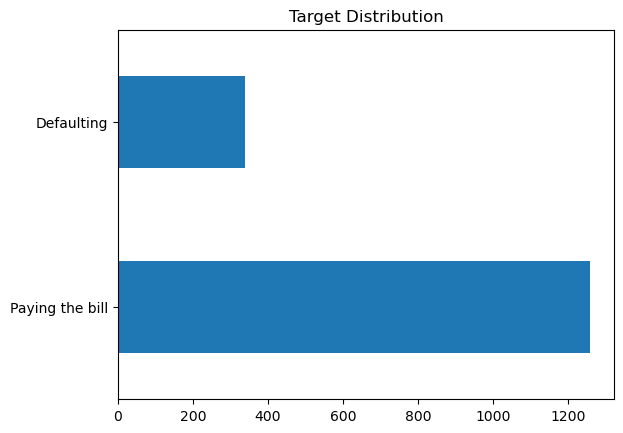

In [10]:
ax = creditDf["Default payment next month"].value_counts().plot(kind='barh', title="Target Distribution")
ax.set_yticklabels(('Paying the bill','Defaulting'))

We can see that default only makes up less than a quarter of the total target distribution, thus we may need to use oversampling techniques to equalize the distribution.

### Features of Dataset
- Credit Limit: This feature represents the maximum amount of credit that the customer is allowed to borrow from the credit card company.

- Gender: This feature represents the customer's gender, either male or female.

- Education: This feature represents the customer's level of education, which could be high school, university, or post-graduate .

- Marriage Status: This feature represents the customer's marital status, which could be single, married.

- Age: This feature represents the customer's age in years.

- Bill_Amount 1 - 3: This feature represents the amount of credit card bill that the customer generated in the first to third months respectively.

- Pay_Amount 1 - 3: This feature represents the amount of credit card bill that the customer paid in the first to third months respectively.

Customer Id is taken out due to it being a unique value for each row and thus no correlation between any of the other features 

## Bivariate Analysis

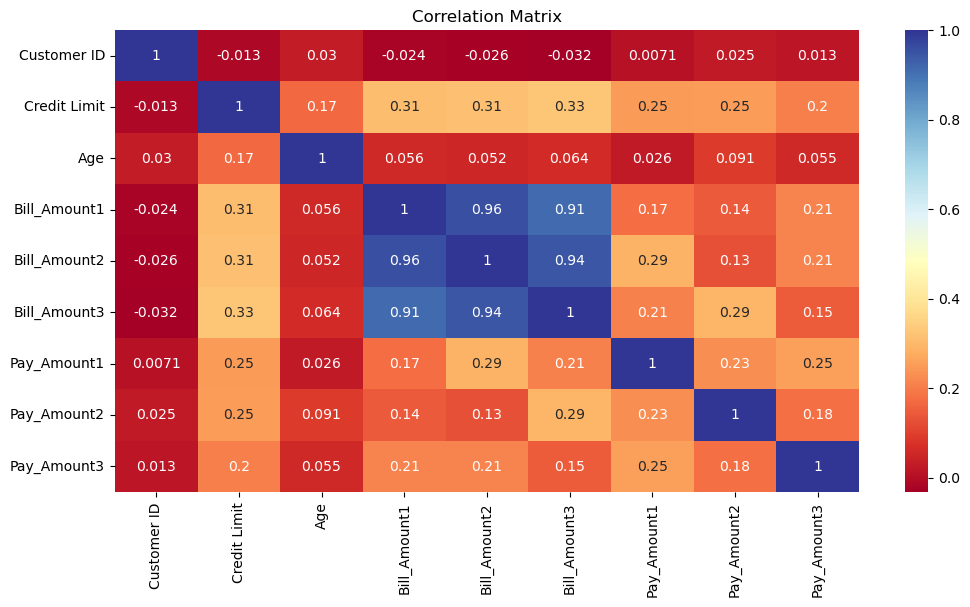

In [11]:
#get pearson correlation
#Getting the Correlation
correlationDf = creditDf.drop(columns=['Gender','Education','Marriage Status','Default payment next month'])
correlation = correlationDf.corr()

#Plotting the Correlation Matrix
plt.figure(figsize=(12, 6))
plt.title("Correlation Matrix")
sns.heatmap(correlation, annot=True, cmap='RdYlBu')
plt.show()

- We can see that Customer Id has a very weak or no correlation(<0.05) to the other features and we can consider discarding the Customer Id variable for further analysis
- Bill Amounts 1 - 3 are highly correlated with each other with a correlation of > 0.90 ,it indicates a strong linear relationship between these variables

##### New DataSet With all the required features and target label

In [12]:
creditDfNew = creditDf.drop(columns=['Customer ID'])
creditDfNew

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1595,480000,female,univeresity,married,35,18214,11031,182123,0,182123,12960,0
1596,150000,female,univeresity,married,37,1184,794,2756,0,2772,0,0
1597,110000,female,post-graduate,single,29,107195,109443,106637,7845,4000,4000,0
1598,240000,male,post-graduate,single,30,7744,7284,11234,7305,11263,10018,0


##### Crammer's V Correlation:
$$
    V = \sqrt{\frac{\chi^2 / n}{\min(k - 1, r - 1)}}
$$
Crammer's V Correlation is a measure of association between two categorical variables. It is used to assess the strength and direction of the relationship between two nominal or ordinal variables. This allows us to measure the correlation between the categorical variables by encoding it using label encoder

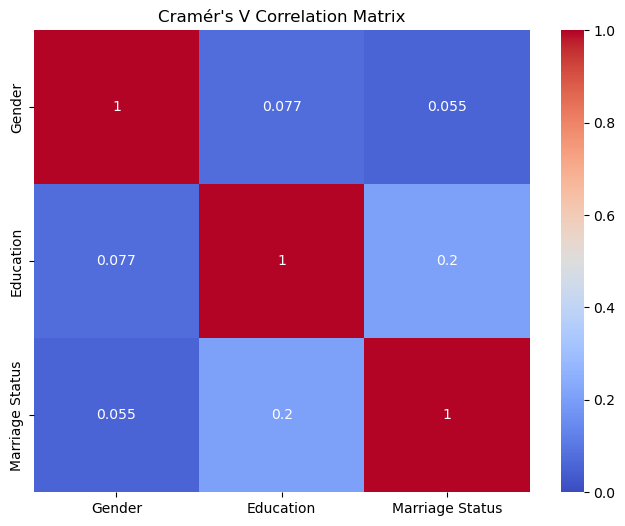

In [13]:
#maybe put inside
label_encoder = LabelEncoder()
df_encoded = creditDfNew[['Gender','Education','Marriage Status']].apply(label_encoder.fit_transform)

# Function to calculate Cramér's V correlation
def cramers_corrected_stat(confusion_matrix):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calculate Cramér's V correlation matrix
corr_matrix = pd.DataFrame(index=df_encoded.columns, columns=df_encoded.columns)
for var1 in df_encoded.columns:
    for var2 in df_encoded.columns:
        confusion_matrix = pd.crosstab(df_encoded[var1], df_encoded[var2])
        corr_matrix.loc[var1, var2] = cramers_corrected_stat(confusion_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramér's V Correlation Matrix")
plt.show()

- The categorical variables are not strong correlated with each other with all of them being less than 0.2 

Text(0.5, 1.02, 'Pairwise Relationships of Credit Data by Default Payment Status')

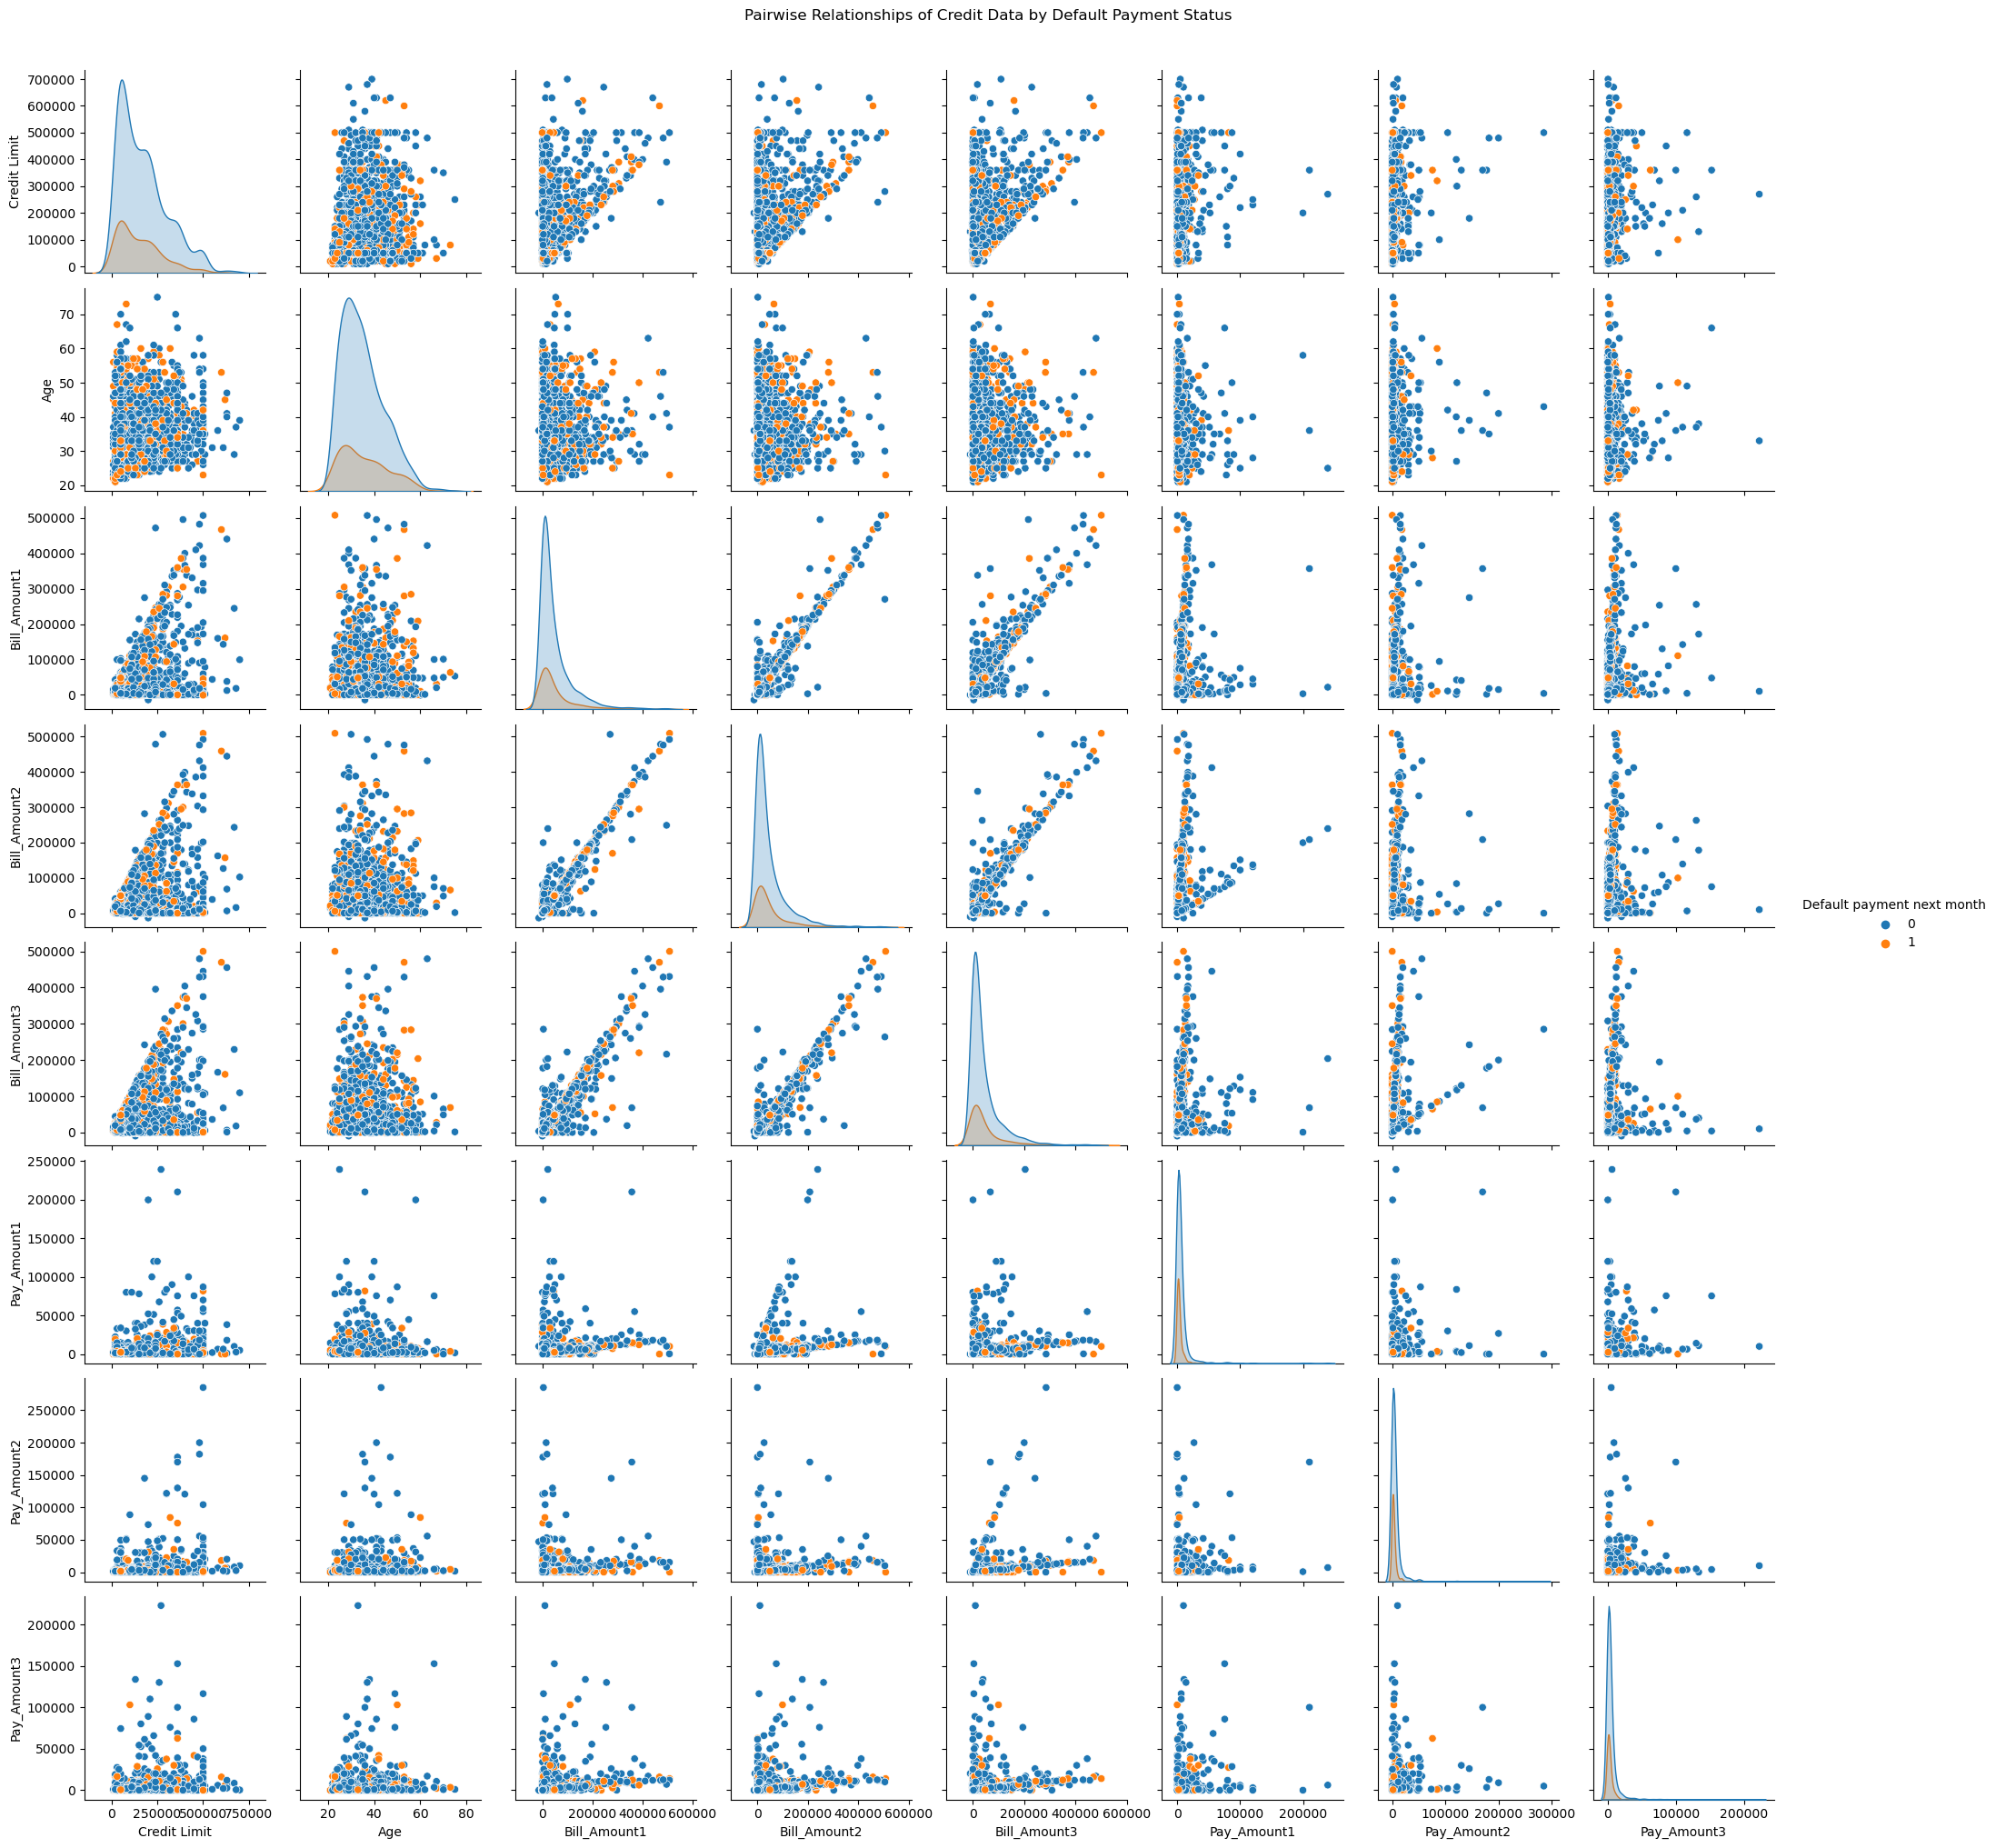

In [14]:
#Plotting the Pairplot to see the corr
sns.pairplot(creditDfNew, hue="Default payment next month")
plt.suptitle("Pairwise Relationships of Credit Data by Default Payment Status", y=1.02)

Just like the HeatMap, we can see that the correlation between the bill amounts have the highest correlation
- We can see that the distribution for most of the features are skewed to the left and thus we need a (Power transformer) to scale our data

## Univariate Variable analysis 

In [15]:
#univariate
fig = px.histogram(creditDfNew, x='Gender',color='Default payment next month', barmode='group', title='Distribution of Gender by Default Payment Next Month',nbins=20)
fig.show()
percentageGender = creditDfNew.groupby('Gender')['Default payment next month'].value_counts(normalize=True) * 100
print(percentageGender)

fig2 = px.histogram(creditDfNew,x='Education',color='Default payment next month', barmode='group', title='Distribution of Education by Default Payment Next Month',nbins=20)
fig2.show()
percentageEducation = creditDfNew.groupby('Education')['Default payment next month'].value_counts(normalize=True) * 100
print(percentageEducation)

fig3 = px.histogram(creditDfNew,x='Marriage Status',color='Default payment next month', barmode='group', title='Distribution of Marriage Status by Default Payment Next Month',nbins=20)
fig3.show()
percentageMarriageStatus = creditDfNew.groupby('Marriage Status')['Default payment next month'].value_counts(normalize=True) * 100
print(percentageMarriageStatus)



Gender  Default payment next month
female  0                             78.510638
        1                             21.489362
male    0                             79.090909
        1                             20.909091
Name: Default payment next month, dtype: float64


Education      Default payment next month
high school    0                             75.179856
               1                             24.820144
post-graduate  0                             81.291391
               1                             18.708609
univeresity    0                             77.994429
               1                             22.005571
Name: Default payment next month, dtype: float64


Marriage Status  Default payment next month
married          0                             77.032810
                 1                             22.967190
single           0                             80.088988
                 1                             19.911012
Name: Default payment next month, dtype: float64


We note that:
- Females has a slightly higher percentage of defaulting payment as compared to males
- High School has the highest percentage among the education column
- Married customers tend to default more than single customers

## Data Preparation
To start training our model, we need to first prepare the data by doing these few steps:
- Feature Generation
- Encoding Categorical Columns
- Seperating X and y & Splitting Train and Test sets
- Scaling the data

### Feature Generation
**Did you process the features in any way?**

- We will be adding a new feature called Total Pay Amount, it is created by by summing the Pay amounts of the 3 months together
- This aims to help the model to better capture the underlying patterns and relationships in the data.

In [16]:
creditDfNew1 = creditDfNew.copy()
creditDfNew1['Total_Pay_Amount'] = creditDf['Pay_Amount1'] + creditDf['Pay_Amount2'] + creditDf['Pay_Amount3']

creditDfNew1


,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month,Total_Pay_Amount
0,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1,689
1,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1,2000
2,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0,4018
3,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0,5219
4,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0,48681
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,480000,female,univeresity,married,35,18214,11031,182123,0,182123,12960,0,195083
1596,150000,female,univeresity,married,37,1184,794,2756,0,2772,0,0,2772
1597,110000,female,post-graduate,single,29,107195,109443,106637,7845,4000,4000,0,15845
1598,240000,male,post-graduate,single,30,7744,7284,11234,7305,11263,10018,0,28586


### Encoding Catergorical Columns
It is nescessary to encode our categorical columns using pandas.get_dummies and sklearn.LabelBinarizer for categories that have multiple unqiue values and categories that have only 2 unqiue values

In [17]:
creditDfEncoded = creditDfNew1.copy()
# define the categories in order
categories = ['high school', 'post-graduate', 'univeresity']
# define ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=[categories])

# fit and transform the ordinal encoder on the dataset
encodedEducation = ordinal_encoder.fit_transform(creditDfEncoded[['Education']])

# create a LabelBinarizer object
encoder = LabelBinarizer()
# fit and transform the DataFrame
encodedGender = encoder.fit_transform(creditDfEncoded['Gender'])#female = 0, male =1
encodedMarriage = encoder.fit_transform(creditDfEncoded['Marriage Status'])#married = 0 , single = 1

creditDfEncoded = creditDfEncoded.drop(columns=['Gender', 'Marriage Status','Education'])

creditDfEncoded = pd.concat([creditDfEncoded, pd.DataFrame(encodedGender, columns=['Gender']), pd.DataFrame(encodedMarriage, columns=['Marriage Status']),pd.DataFrame(encodedEducation, columns=['Education'])], axis=1)
creditDfEncoded

,Credit Limit,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month,Total_Pay_Amount,Gender,Marriage Status,Education
0,20000,24,3913,3102,689,0,689,0,1,689,0,0,2.0
1,120000,26,2682,1725,2682,0,1000,1000,1,2000,0,1,2.0
2,90000,34,29239,14027,13559,1518,1500,1000,0,4018,0,1,2.0
3,50000,37,46990,48233,49291,2000,2019,1200,0,5219,0,0,2.0
4,50000,57,8617,5670,35835,2000,36681,10000,0,48681,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,480000,35,18214,11031,182123,0,182123,12960,0,195083,0,0,2.0
1596,150000,37,1184,794,2756,0,2772,0,0,2772,0,0,2.0
1597,110000,29,107195,109443,106637,7845,4000,4000,0,15845,0,1,1.0
1598,240000,30,7744,7284,11234,7305,11263,10018,0,28586,1,1,1.0


The values of the new columns after encoding are:
   - Gender:
        - 0 = Female
        - 1 = Male
   - Marriage Status:
        - 0 = Married
        - 1 = Single
   - Education:
        - 0 = high-school
        - 1 = post-graduate
        - 2 = univeresity	


### Seperation of Target Label and features and Spliting our Training and Test datasets 
We then seperate our target data and features into y and X respectively
By splitting the data into training and testing sets, we can measure how well our model generalizes to new, unseen data. This allows us to avoid overfitting and ensures that our model is robust enough to make accurate predictions on new data.

In [18]:
X = creditDfEncoded.drop(columns=['Default payment next month'])
y = creditDfEncoded['Default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)
X_train2 = X_train.copy()
y_train2 = y_train.copy()
X_test2 = X_test.copy()
y_test2 = y_test.copy()
y_train2

1135    0
521     0
1447    0
1550    1
1172    0
       ..
1525    0
1382    0
351     0
1091    0
1433    0
Name: Default payment next month, Length: 1280, dtype: int64

### Standardization 
We scale the data to prevent bias in the model as features can dominate the others in terms of their influence on the model. This can create bias in the model, leading to incorrect predictions.it also improves model performance.Some machine learning algorithms, such as K-nearest neighbors and SVMs, work better when the features are standardized. 
> We will be using Robust Scaler as it uses statistics that are robust to outliers, such as the median and interquartile range (IQR).It also does not assume any specific distribution. It uses the median and IQR to normalize the data, preserving the relative order and shape of the original distribution.

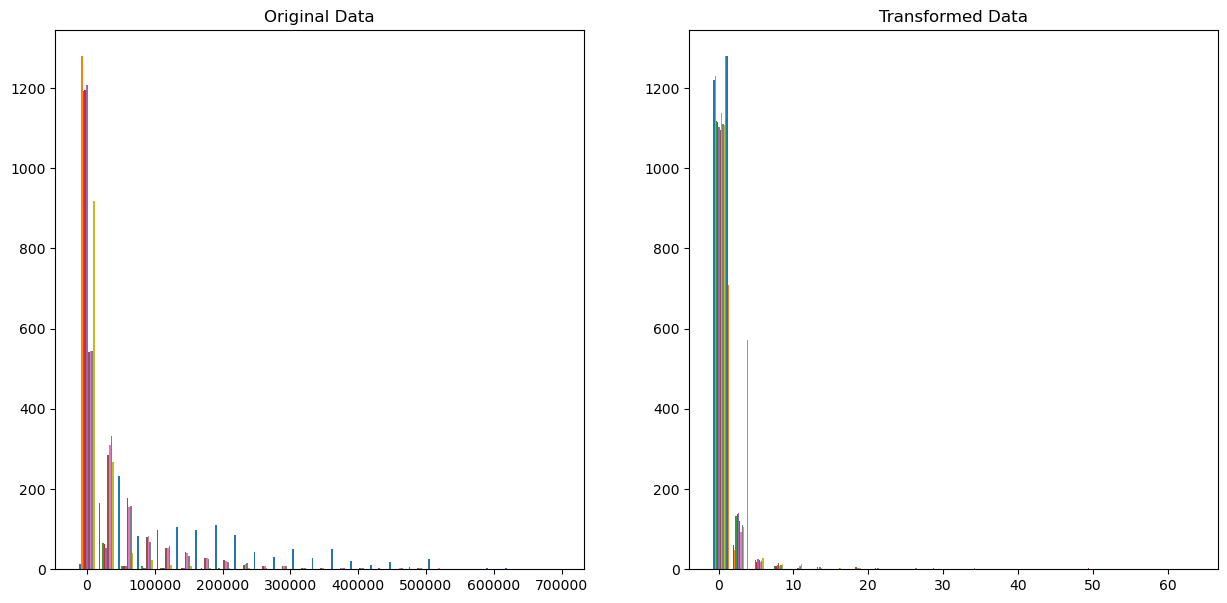

In [19]:
from sklearn.preprocessing import RobustScaler
RobustScaler = RobustScaler()

columns_to_scale = ['Credit Limit', 
                    'Age' , 
                    'Pay_Amount1', 
                    'Pay_Amount2', 
                    'Pay_Amount3', 
                    'Bill_Amount1', 
                    'Bill_Amount2', 
                    'Bill_Amount3',
                    'Total_Pay_Amount']


X_train2[columns_to_scale] = RobustScaler.fit_transform(X_train2[columns_to_scale])
X_test2[columns_to_scale] = RobustScaler.transform(X_test2[columns_to_scale])

# plot the original and transformed data
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].hist(X_train[columns_to_scale], bins=25)
axs[0].set_title("Original Data")
axs[1].hist(X_train2, bins=25)
axs[1].set_title("Transformed Data")
plt.show()

## Creating our Model
##### Evaluation Metrics
- Recall:
$$
    Recall = \frac{True Positive}{True Positive + False Negatives}
$$
- We will be using recall as the Recall score is a metric used to evaluate the model's performance in correctly identifying true positives among all actual positive instances. In this case, it is particularly suitable because our goal is to have a high recall score, indicating that we can accurately identify a significant number of customers who are likely to default on their payments. This metric is crucial in ensuring that we capture as many potential defaulters as possible.

##### Evaluation Methodology
- To select candidate models, We will be using k-Fold Cross Validation on the training set. This approach provides a robust estimation of model performance by splitting the data into k subsets and evaluating each model on different subsets.

##### Scoring Metrics
- To evaluate the model's performance, We will primarily use the confusion matrix and related metrics. These metrics provide insights into the model's ability to correctly classify instances, especially focusing on identifying customers who might default on their payments.

#### Pipeline

In [20]:
from sklearn.preprocessing import RobustScaler

featurestoscale = [
    "Credit Limit","Bill_Amount1","Bill_Amount2","Bill_Amount3","Pay_Amount1","Pay_Amount2","Pay_Amount3","Total_Pay_Amount",
]

scaler = Pipeline(
    steps=[("Scaler", RobustScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("Numeric", scaler, featurestoscale)
    ]
)

steps = [
    ('preprocessing', preprocessor),
    ('model'),
]

step = len(steps) - 1

Pipelines are used to prevent data from leaking which produces more reliable and accurate model evaluations.

In [21]:
models = {
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Networks': MLPClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Stochastic Gradient Descent': SGDClassifier()
}

cv = KFold(n_splits=5, random_state=42, shuffle=True)
score = ['precision', 'recall', 'f1', 'accuracy']

We specify the models we want to compare and initializes kfold cross validation with 5 splits with the scoring metrices used.


,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_accuracy,train_accuracy
Gaussian Naive Bayes,0.007800,0.004798,0.227262,0.228249,0.929804,0.927534,0.363933,0.366283,0.313281,0.318359
Decision Trees,0.009422,0.004809,0.276155,0.985194,0.288063,0.980693,0.279651,0.982922,0.685937,0.992773
Random Forest,0.270016,0.015217,0.368225,0.979956,0.104957,0.986139,0.162636,0.983015,0.771094,0.992773
Gradient Boosting,0.302291,0.005183,0.338571,0.974114,0.076437,0.367045,0.124033,0.532689,0.775000,0.863281
K-Nearest Neighbors,0.006855,0.015882,0.313034,0.677366,0.132196,0.300743,0.181850,0.416257,0.760156,0.820898
Neural Networks,0.537621,0.005800,0.766667,0.854060,0.022489,0.037893,0.042802,0.072106,0.788281,0.793750
AdaBoost,0.123394,0.009800,0.428889,0.750751,0.057429,0.122575,0.100902,0.209489,0.782813,0.804688
Extra Trees,0.157447,0.017158,0.376712,0.985194,0.108786,0.980693,0.167782,0.982922,0.770312,0.992773
Stochastic Gradient Descent,0.006835,0.005583,0.291184,0.304281,0.137546,0.150567,0.169128,0.185273,0.729688,0.734766


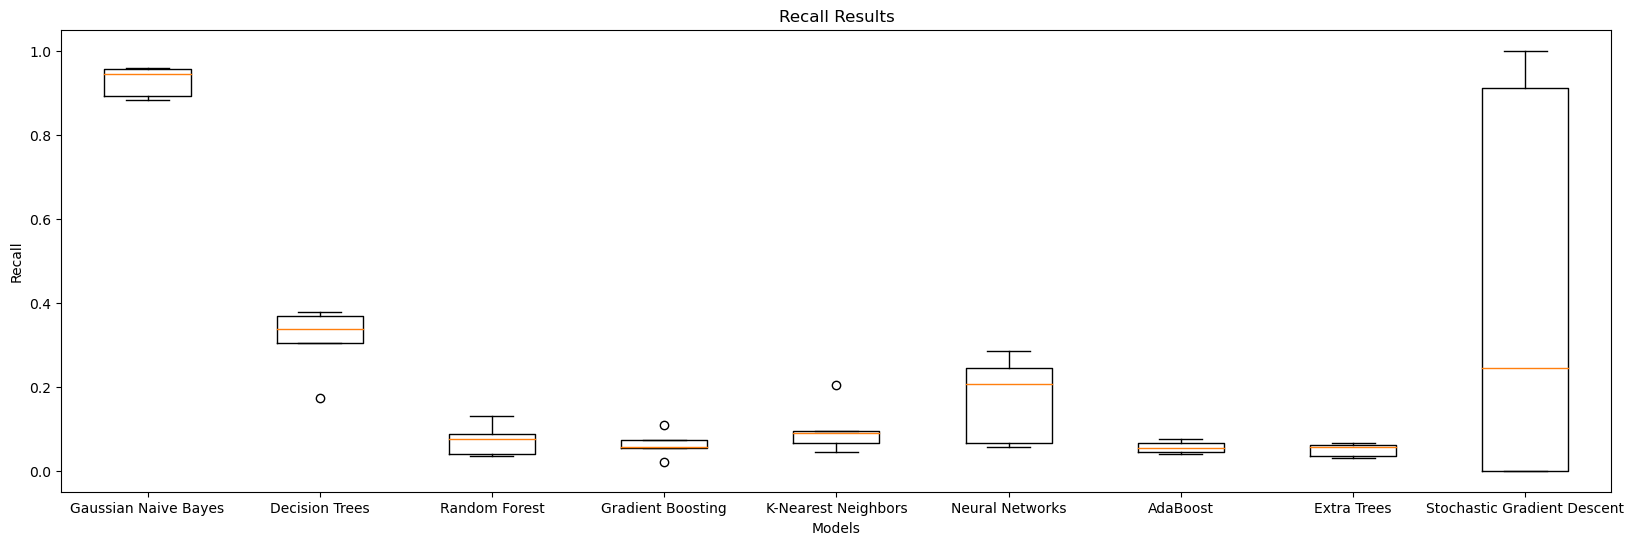

In [22]:
filterwarnings('ignore')

display(create_results_dataframe(models, X_train, y_train, score, cv, steps, step))
plot_boxplots(models, X_train, y_train,'recall',cv)


We can see that Guassian Naive Bayes has the highest recall score among the models

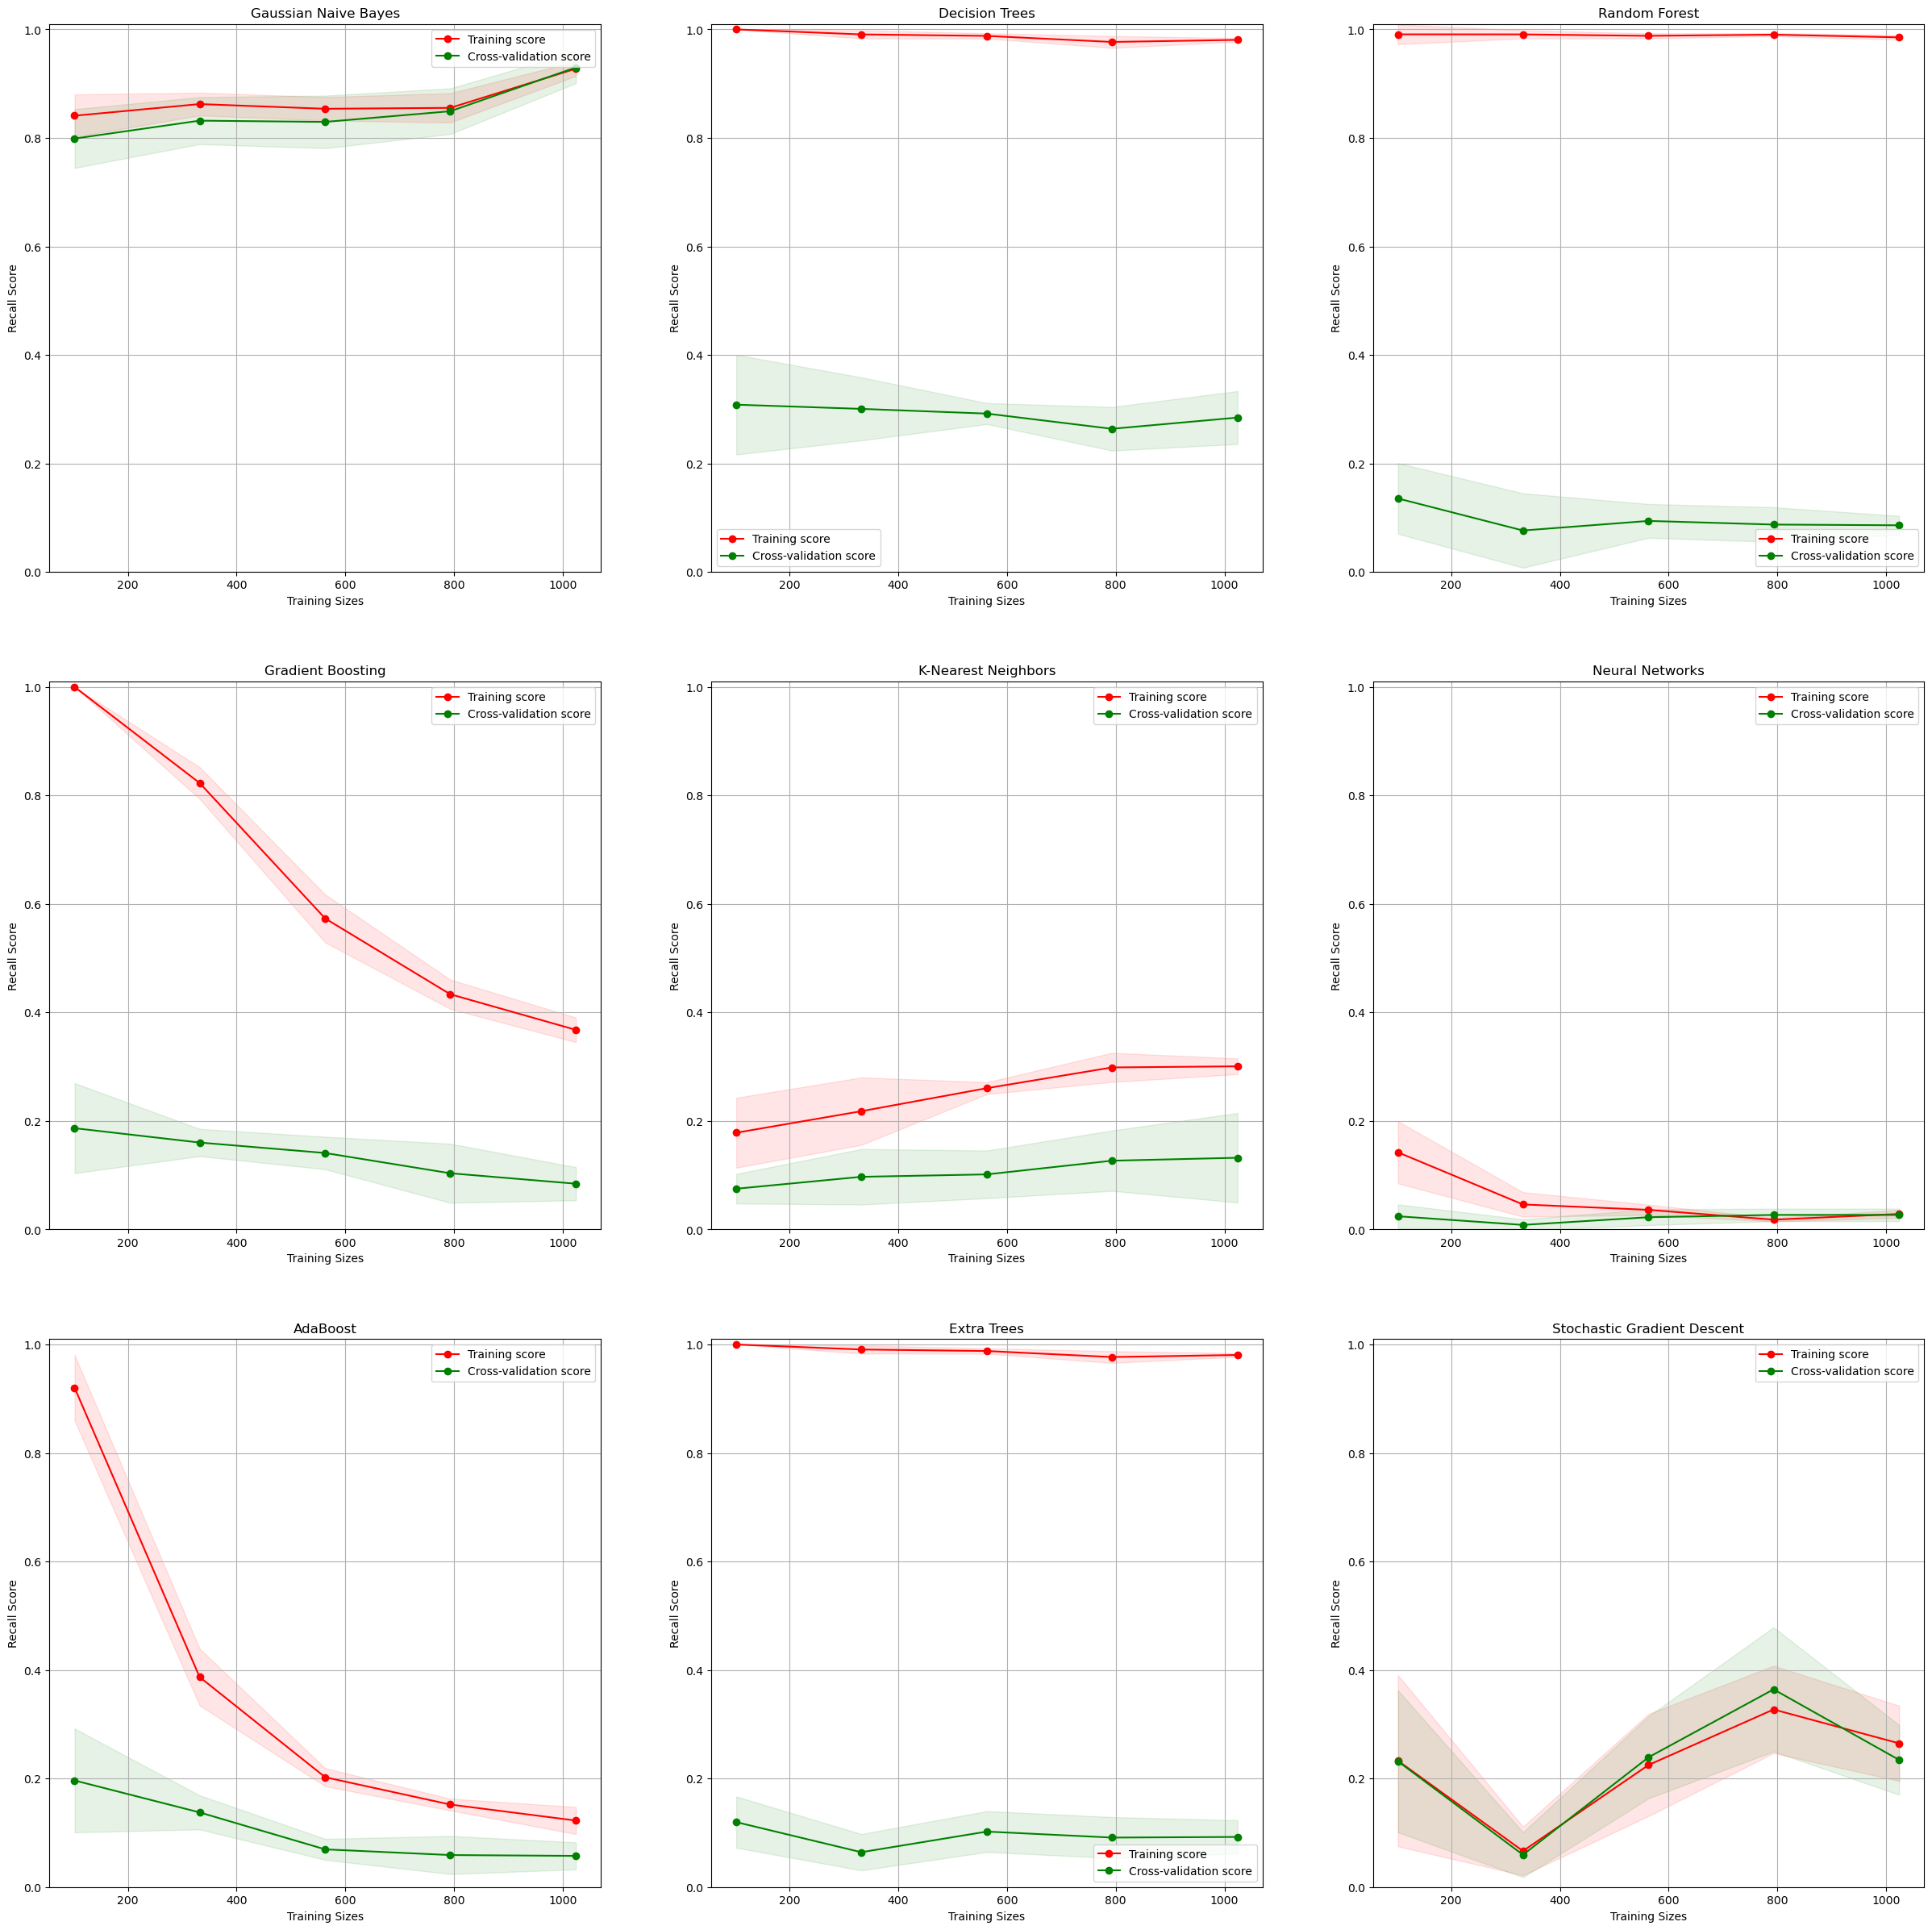

In [23]:
filterwarnings('ignore')

plot_multiple_learning_curves(models, X_train, y_train,cv,'recall',steps, step)

Although GaussianNB does not show significant improvement when more data is fitted to it, it still performs adequately in terms of bias. However, the model exhibits higher variance, suggesting that it is sensitive to the specific training instances and may not generalize well to unseen data.

Despite its limitations, GaussianNB remains the most suitable choice among the other models considered. While it may not be a standout or exceptional model, it is the most reasonable option given the available alternatives, due to its high recall in predicting customer defaults.

## Selection of Model
__How did you select which learning algorithm to use?__

**GaussianNB** is a simple and efficient classification algorithm that is well-suited for tasks involving small to medium-sized datasets.It has the highest recall among the models that I have choosen.GaussianNB is robust to irrelevant features and can handle multiclass classification problems. While it may not capture complex relationships between features, it offers good performance in many practical scenarios and is computationally efficient.


#### Creating a Baseline Model
Creating a baseline model is an important tool in machine learning because it provides a starting point for comparison

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_accuracy,train_accuracy
Dummy Classifier,0.006813,0.006985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.787500,0.787500


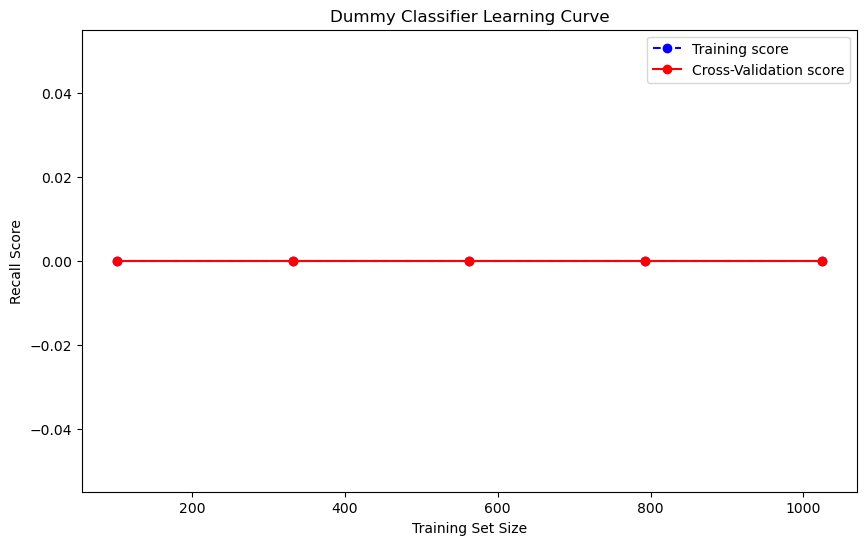

In [24]:
filterwarnings('ignore')

model = {'Dummy Classifier': DummyClassifier()}

display(create_results_dataframe(model, X_train, y_train, score, cv, steps, step))
plot_learning_curve(DummyClassifier(), 'Dummy Classifier Learning Curve', X_train, y_train,cv,steps, step)

**Why is the Recall score of the Dummy Classifier constantly 0?**

This is because the DummyClassifier has different strategies for making predictions, such as 'stratified', 'most_frequent', 'uniform', and 'constant'. The default strategy is 'stratified', which generates predictions by respecting the training set's class distribution.

In the case of a binary classification problem with imbalanced classes, where one class is dominant and the other is rare, the 'stratified' strategy will predict the dominant class most of the time. Consequently, the recall for the rare class will be very low or even zero, as the DummyClassifier does not learn any meaningful patterns or rules from the data.

Therefore, when there is a continuous recall score of 0 for the rare class(customer defaulting = 1) with the DummyClassifier, it indicates that the classifier is not able to correctly predict any instances of the rare class, resulting in low or zero recall for that class.

#### Comparing Baseline and GaussianNB(Default parameters) Models

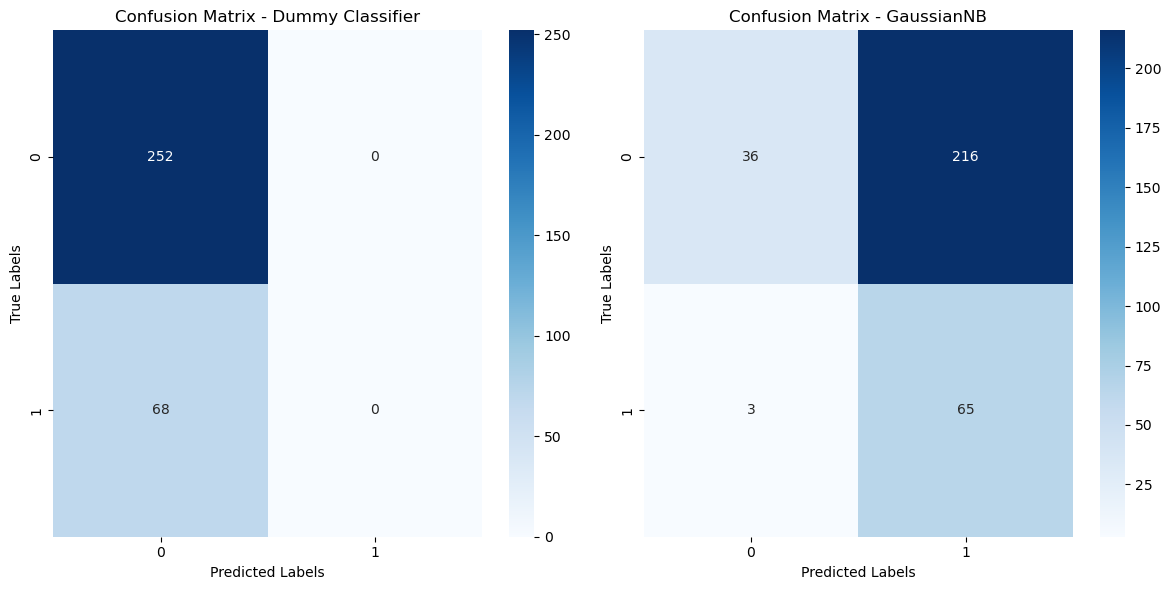

Classification Report - Dummy Classifier:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       252
           1       0.00      0.00      0.00        68

    accuracy                           0.79       320
   macro avg       0.39      0.50      0.44       320
weighted avg       0.62      0.79      0.69       320

-----------------------------------------
Classification Report - GaussianNB:
              precision    recall  f1-score   support

           0       0.92      0.14      0.25       252
           1       0.23      0.96      0.37        68

    accuracy                           0.32       320
   macro avg       0.58      0.55      0.31       320
weighted avg       0.78      0.32      0.27       320



In [25]:
filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train2, y_train2)

dtc_clf = GaussianNB()
dtc_clf.fit(X_train2, y_train2)

dummy_preds = dummy_clf.predict(X_test2)
dtc_preds = dtc_clf.predict(X_test2)

dummy_cm = confusion_matrix(y_test2, dummy_preds)
dtc_cm = confusion_matrix(y_test2, dtc_preds)
dummy_report = classification_report(y_test2, dummy_preds)
dtc_report = classification_report(y_test2, dtc_preds)


# Plot the confusion matrices using heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot Dummy Classifier Confusion Matrix
sns.heatmap(dummy_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Dummy Classifier')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Plot RandomForestClassifier Confusion Matrix
sns.heatmap(dtc_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - GaussianNB')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# Print classification reports based on recall
print("Classification Report - Dummy Classifier:")
print(dummy_report)
print("-----------------------------------------")
print("Classification Report - GaussianNB:")
print(dtc_report)

We can see that:
- The same problem has occured in the dummy classifier
- GaussianNb performs significantly better than the dummy classifer. This indicates that GaussianNB is able to learn patterns and make predictions that are more aligned with the actual class labels.

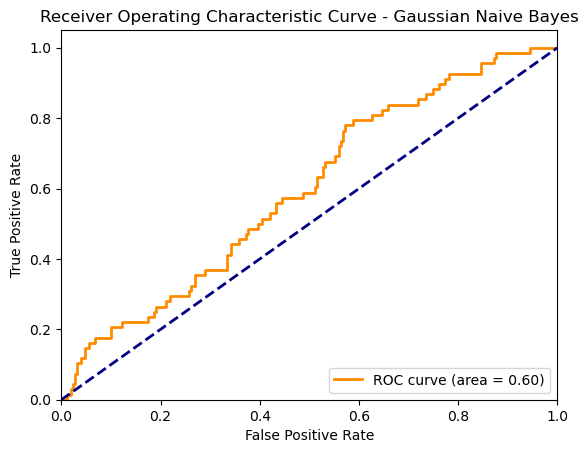

,fit_time,score_time,test_score,train_score
Gaussian Naive Bayes,0.002396,0.001799,0.92696,0.929417


In [26]:
models = {
    'Gaussian Naive Bayes': GaussianNB()
}

# Assume X and y are your features and labels.
create_aucroc_curve(models, X_train2, y_train,X_test2,y_test,'recall', cv)

 - The ROC curve for GaussianNB is subpar which is only marginally better than a random guess (AUC = 0.5).
 - This may be because even though the model has a **high true positive rate**, it has a really **low false positive rate** as seen in the confusion matrix above.
 
 As the ROC curve illustrates the trade-off between the TPR and FPR for various classification thresholds. In the case of GaussianNB, its suboptimal performance is characterized by a TPR that is relatively high while the FPR remains low. This indicates that the model tends to correctly identify positive instances but also incorrectly classifies a considerable number of negatives as positives.

### Feature Importance

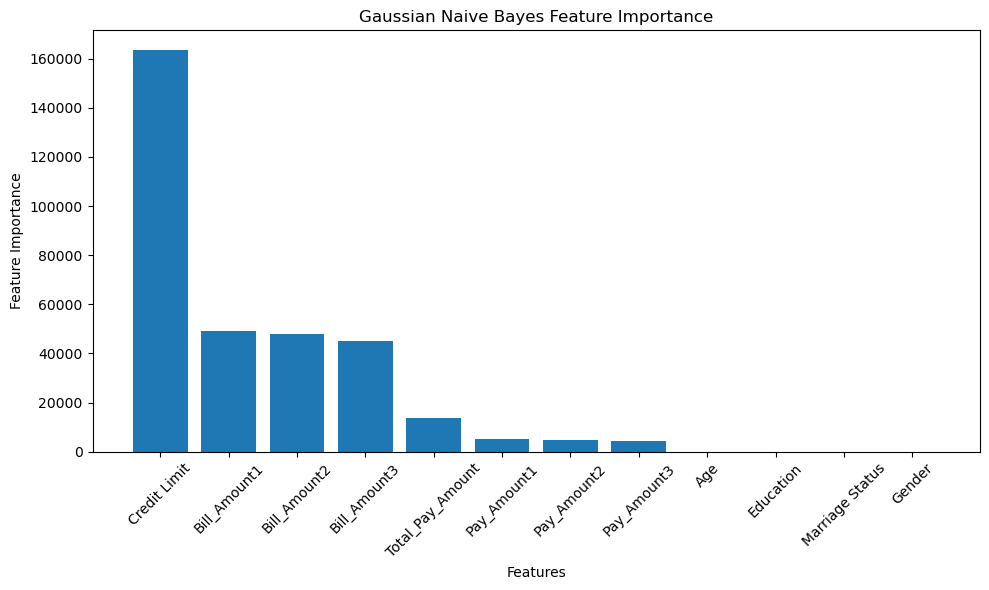

In [27]:
# change to decision tree
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Access model parameters
mean_values = gnb.theta_  # Mean values for each feature in each class

# Calculate feature importance measure (e.g., mean)
importance_measure = np.mean(mean_values, axis=0)  # Use mean values as an importance measure

# Sort the feature importance in descending order
indices = np.argsort(importance_measure)[::-1]
sorted_importance = importance_measure[indices]


# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), sorted_importance)
plt.xticks(range(len(sorted_importance)),  X.columns[indices], rotation=45)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Gaussian Naive Bayes Feature Importance')
plt.tight_layout()
plt.show()


- Credit Limit has the highest importance, this maybe explained with customers having more credit limit, there is a lower chance of defaulting on payment as they have more financial flexibility and can afford their expenses.
- Age, Education, Marriage Status, Gender has the lowest importance among the other features. This implies that these 4 features have relatively less influence or relevance compared to other features in determining the final predictions.

## HyperParameter Tuning
**Did you try to tune the hyperparameters of the learning algorithm, and in that case how?**
- We will be using GridsearchCV to find the best parameters
- Gridsearch tests every single combination of hyperparameters to find the best score using cross validation
- Eventhough Gridseach is less efficient than Randomsearch, our hyperparameter space is relatively small, thus it is a much better choice to use Gridsearch

In [28]:
print("Gaussian Naive Bayes Hyperparameters:")
for param_name in GaussianNB().get_params().keys():
    print(param_name)

Gaussian Naive Bayes Hyperparameters:
priors
var_smoothing


In [29]:
model = GaussianNB()

# Define the parameter grid to search over
param_grid = {
    'priors': [[0.1,0.9],[0.3, 0.7],[0.5, 0.5]],
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
}

# Create the decision tree classifier

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=cv)
grid_search.fit(X_train2, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_


# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'priors': [0.1, 0.9], 'var_smoothing': 0.1}
Best Score: 0.966660577274388


In [30]:

model1 = GaussianNB(**best_params)
score = ['accuracy', 'precision', 'recall', 'f1']

scoring = []
resultsdf = pd.DataFrame()

cv_scores = cross_validate(model1, X_train2, y_train,scoring=score, cv=cv,return_train_score=True)
scoring.append(pd.Series(cv_scores).apply(np.mean, axis=0))
resultsdf = pd.DataFrame(scoring)

model1.fit(X_train2, y_train)

model1_preds = model1.predict(X_test2)

# Create the confusion matrix for the RandomForestClassifier
dtc_cm = confusion_matrix(y_test, model1_preds)

dtc_report = classification_report(y_test, model1_preds)
display(resultsdf)
print(dtc_report)


,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.00203,0.003402,0.271875,0.271094,0.221741,0.221447,0.966661,0.966117,0.359424,0.360243


              precision    recall  f1-score   support

           0       1.00      0.05      0.09       252
           1       0.22      1.00      0.36        68

    accuracy                           0.25       320
   macro avg       0.61      0.52      0.23       320
weighted avg       0.83      0.25      0.15       320



### Validation Curves
Validation curves helps in assessing the impact of varying hyperparameter values on the model's performance

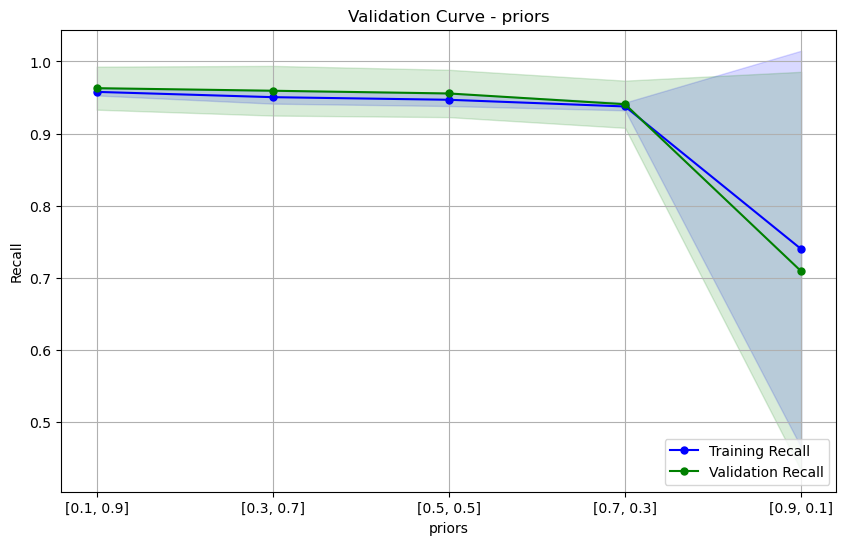

In [31]:
param_range = [[0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]

plot_validation_curve(GaussianNB(), X_train2, y_train, param_name="priors", param_range=param_range, cv=cv, scoring='recall')

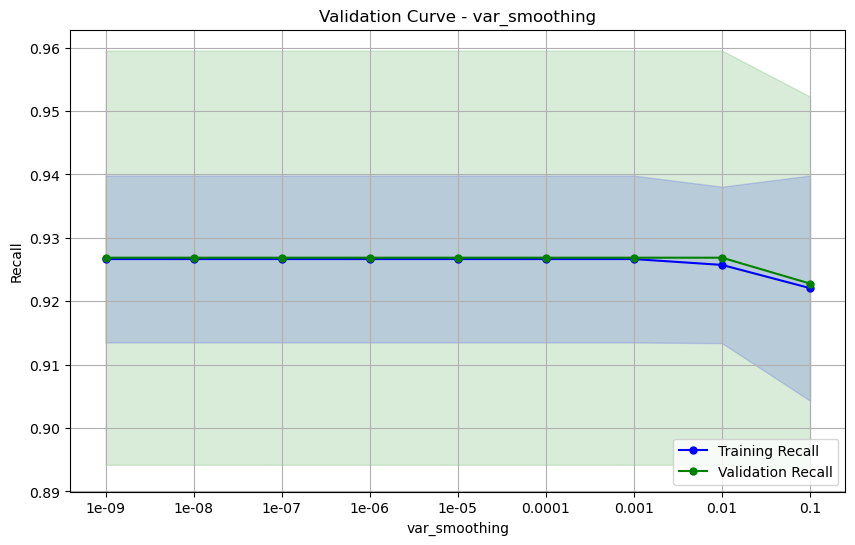

In [32]:
param_range = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

plot_validation_curve(GaussianNB(), X_train2, y_train, param_name="var_smoothing", param_range=param_range, cv=cv, scoring='recall')

### Final Model

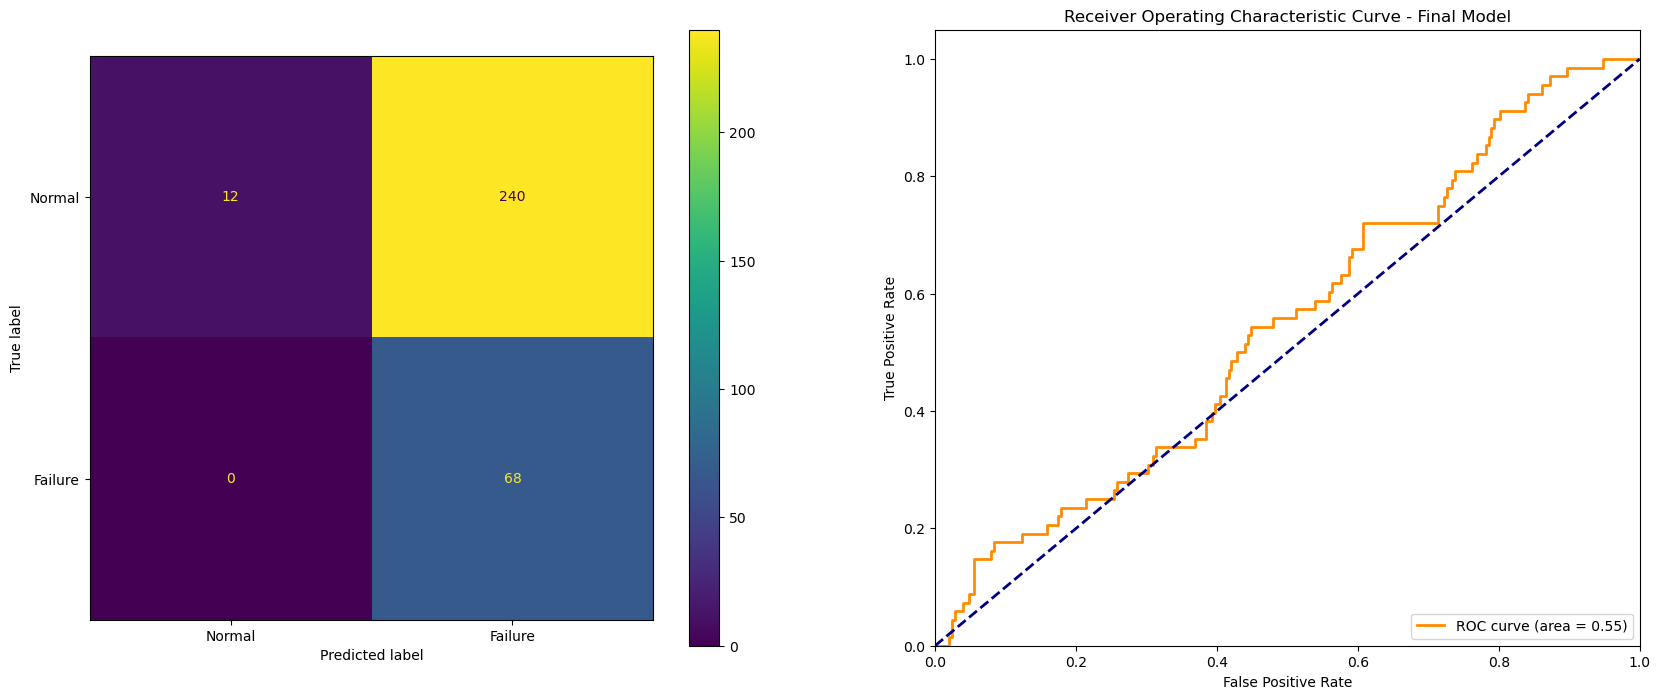

<Figure size 640x480 with 0 Axes>

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

labels = ['Normal', 'Failure']

model1 = GaussianNB(**best_params)

score = ['accuracy', 'precision', 'recall', 'f1']
model1.fit(X_train2, y_train)
model1_preds = model1.predict(X_test2)
dtc_cm = confusion_matrix(y_test, model1_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=dtc_cm, display_labels=labels)
disp.plot(ax=ax1)

# Fit the model to the training data.
model1.fit(X_train2, y_train)

# Get the predicted probabilities from the model.
y_score = model1.predict_proba(X_test2)[:, 1]
# Set a threshold to maximize recall
threshold = 0.5  # You can adjust this threshold based on your needs and preference
y_pred = (y_score >= threshold).astype(int)

# Compute recall score
recall = recall_score(y_test, y_pred)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve.
plt.figure()
ax2.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'Receiver Operating Characteristic Curve - Final Model')
ax2.legend(loc="lower right")
plt.show()

Results:
- The confusion matrix of GaussianNb improved with only 2 defaults being predicted wrong
- ROC curve did not improve at all, it even deproved,this maybe because eventhough the true positive rate went up, the false positive rate also went down. As the ROC curve illustrates the trade-off between the TPR and FPR
   - The lack of improvement in the AUC suggests that the model's ability to distinguish between positive and negative instances did not significantly improve.

Despite the improvement in the confusion matrix, the lack of improvement in the ROC curve suggests that the model still struggles with correctly classifying negative instances without generating false positives.

### Saving Model
We will be using the pickle library to save the model

In [34]:
pickle.dump(model1, open("gaussianNB.p", "wb"))
gaussianNb_clf = pickle.load(open("gaussianNB.p", "rb"))

#### References
Random Oversampling image - https://dagshub.com/blog/imbalance-dataset-test-and-validate-resampled-tabular-data/

VFC-SMOTE: very fast continuous synthetic minority oversampling for evolving data streams - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Comparison-between-Smote-and-Borderline-Smote-using-K-6_fig1_354585188 [accessed 1 May, 2023]

### Oversampling (Extra)
We use oversampling in machine learning to address class imbalance, where one class of the target variable is significantly underrepresented in the dataset(Customers defaulting on their payment). In such cases, the predictive model may be biased towards the majority class and perform poorly on the minority class. 

#### Random Oversampling
Random oversampling involves randomly duplicating or creating new instances of the minority class to balance the class distribution. The goal is to increase the representation of the minority class and provide the classifier with more examples to learn from.

![random-oversampling.png](attachment:random-oversampling.png)

In [35]:
#tune the hyperparameters
ros = RandomOverSampler(random_state=42)

# fit and resample the data
X_random_res, y_random_res = ros.fit_resample(X_train, y_train)

#Plotting Histogram to see the distribution of the target variable
fig = px.histogram(y_random_res,x='Default payment next month',color='Default payment next month', title='Target Distribution After Borderline SMOTE')
fig.update_layout(width=800, height=500)
fig.show()

#### Borderline SMOTE
Another popular oversampling techinque is Borderline SMOTE(Synthetic Minority Over-sampling Technique) technique, Borderline SMOTE is suitable over SMOTE is because, By focusing on the informative minority class samples near the borderline.Borderline SMOTE can generate synthetic samples that are more representative of the minority class and less likely to be noisy, compared to SMOTE which generates synthetic samples indiscriminately across the entire feature space.
 
 ![Comparison-between-Smote-and-Borderline-Smote-using-K-6.png](attachment:Comparison-between-Smote-and-Borderline-Smote-using-K-6.png)

 Oversampling will be done only to the train set the prevent the duplicate records from being in the test set upon splitting.

In [36]:
#tune the hyperparameters
sm = BorderlineSMOTE(sampling_strategy='minority', random_state=42)

# fit and resample the data
X_train_smb, y_train_smb = sm.fit_resample(X_train, y_train)

#Plotting Histogram to see the distribution of the target variable
fig1 = px.histogram(y_train_smb,x='Default payment next month',color='Default payment next month', title='Target Distribution After Borderline SMOTE')
fig1.update_layout(width=800, height=500)
fig1.show()

#### BorderLine SMOTE

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
Gaussian Naive Bayes,0.005597,0.004799,0.535220,0.535094,0.519111,0.519164,0.951712,0.950171,0.671341,0.671426
Decision Trees,0.013397,0.004001,0.729169,0.995164,0.718839,0.993095,0.755117,0.997264,0.735763,0.995174
Random Forest,0.374927,0.013601,0.832840,0.995164,0.822562,0.991883,0.847619,0.998501,0.834545,0.995180
Gradient Boosting,0.457232,0.006395,0.734120,0.858631,0.724304,0.842435,0.759580,0.882844,0.740349,0.861677
K-Nearest Neighbors,0.007793,0.014801,0.733641,0.816717,0.698291,0.776135,0.819799,0.890096,0.753853,0.829197
Neural Networks,0.917443,0.006616,0.632439,0.664062,0.613343,0.637720,0.731593,0.761337,0.665252,0.693225
AdaBoost,0.170218,0.010996,0.624006,0.701140,0.621853,0.698044,0.637170,0.713253,0.626235,0.704159
Extra Trees,0.196337,0.016970,0.847729,0.995164,0.834076,0.993095,0.866937,0.997264,0.849845,0.995174
Stochastic Gradient Descent,0.008470,0.003784,0.539173,0.542661,0.545299,0.545257,0.560471,0.572214,0.542205,0.547743


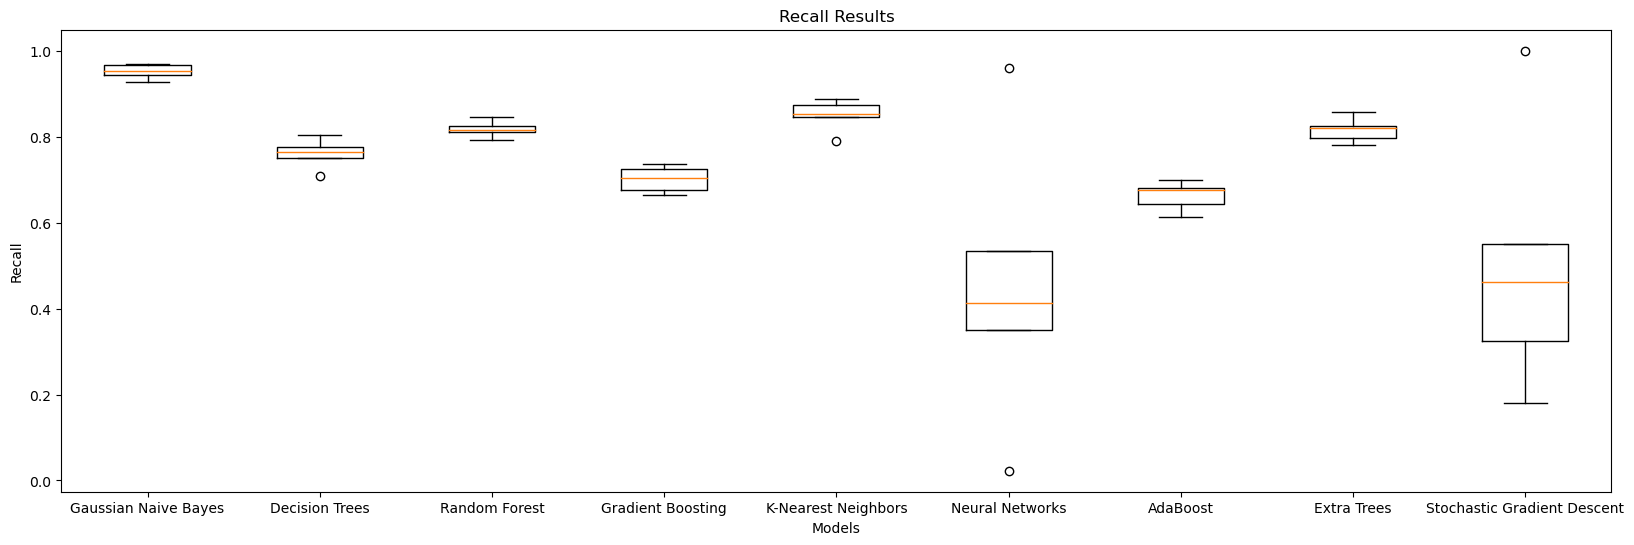

In [37]:
models = {
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Networks': MLPClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Stochastic Gradient Descent': SGDClassifier()
}
display(create_results_dataframe(models, X_train_smb, y_train_smb,score,cv,steps,step))
plot_boxplots(models, X_train_smb, y_train_smb,'recall',cv)

#### Random OverSampling

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
Gaussian Naive Bayes,0.007029,0.004584,0.535221,0.534722,0.519072,0.518904,0.953674,0.953150,0.671818,0.671945
Decision Trees,0.011604,0.003632,0.861608,0.994544,0.804497,0.990167,0.954858,0.999011,0.873012,0.994568
Random Forest,0.326111,0.016166,0.918149,0.994544,0.885083,0.989932,0.960816,0.999255,0.921335,0.994570
Gradient Boosting,0.345618,0.004590,0.767370,0.855281,0.757914,0.857687,0.789648,0.851907,0.772072,0.854480
K-Nearest Neighbors,0.007810,0.016797,0.700407,0.811135,0.670635,0.761894,0.789282,0.905098,0.724404,0.827298
Neural Networks,0.906101,0.005403,0.639405,0.667906,0.622383,0.648573,0.706477,0.737288,0.660617,0.689153
AdaBoost,0.130288,0.009586,0.663700,0.711559,0.675128,0.720776,0.633467,0.690399,0.652492,0.705118
Extra Trees,0.179652,0.016401,0.942954,0.994544,0.930619,0.990167,0.956911,0.999011,0.943520,0.994568
Stochastic Gradient Descent,0.010219,0.005423,0.529761,0.545389,0.524792,0.549880,0.561923,0.590425,0.533105,0.557922


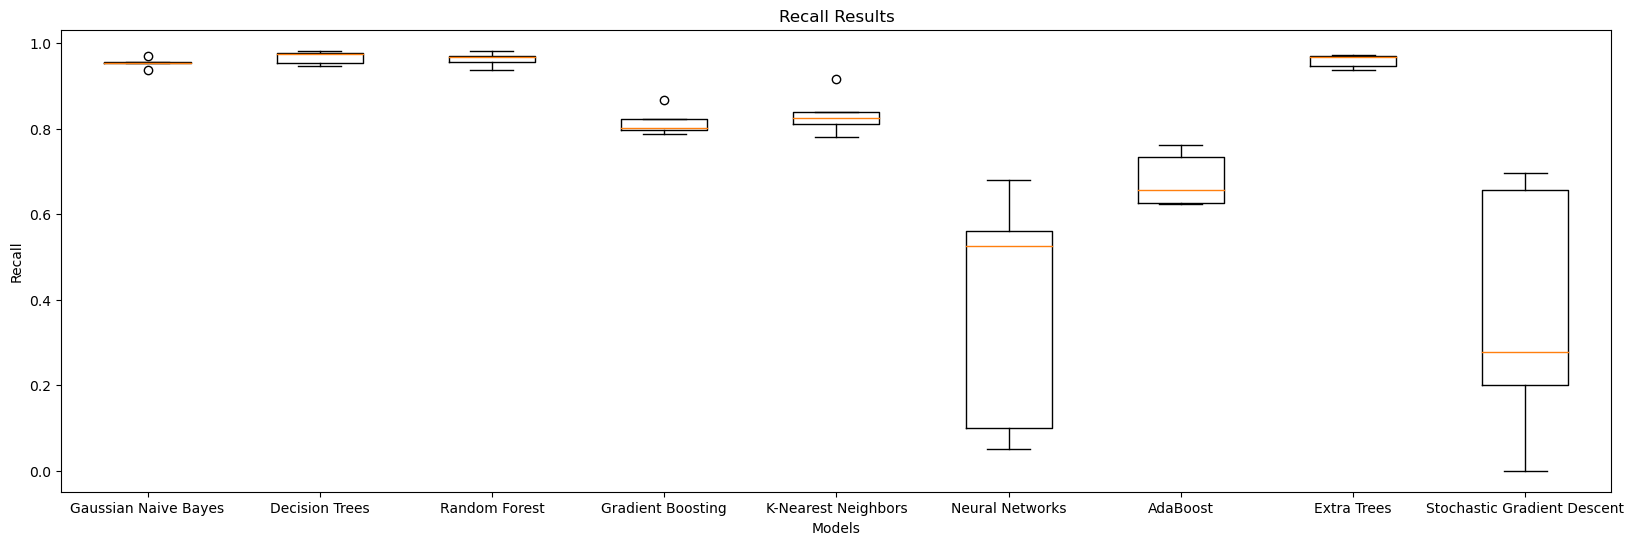

In [38]:
display(create_results_dataframe(models, X_random_res, y_random_res,score,cv,steps,step))
plot_boxplots(models, X_random_res, y_random_res,'recall',cv)

We can see that all the models perform significately better with the oversampling technique, especially the types of decision tree classifers. 

This is because there is a **better Minority Class Representation** with the model gets exposed to more examples of the minority class during training. This helps to improve the representation and learning of the minority class patterns, making the model more capable of correctly identifying and classifying minority class instances.

Oversampling also **reduces the Bias towards Majority Class**,it helps to reduce this bias by providing a more balanced representation of the classes, leading to better recognition and handling of minority class instances.

### Final Model Evaulation

**How do you evaluate the quality of your system?**

In [39]:
final = Pipeline([
    ('preprocessing', preprocessor),
    ('Model', GaussianNB(**best_params))
])

In [40]:
final.fit(X_train, y_train)

y_pred = final.predict(X_test)
y_pred_train = final.predict(X_train)

# Calculate classification metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for (prediction, actual) in ((y_pred, y_test), (y_pred_train, y_train)):
    accuracy_scores.append(accuracy_score(actual, prediction))
    precision_scores.append(precision_score(actual, prediction))
    recall_scores.append(recall_score(actual, prediction))
    f1_scores.append(f1_score(actual, prediction))

final_scores = pd.DataFrame({
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1-score": f1_scores
}, index=["Test", "Train"])
display(final_scores)


,Accuracy,Precision,Recall,F1-score
Test,0.250000,0.220779,1.000000,0.361702
Train,0.270313,0.220911,0.963235,0.359396


## Conclusion
We have successfully created a model that is able to predict if whether or not a customer has defaulted. Through extensive feature engineering, we have been able to develop a simple model that is able to predict if whether or not a customer has defaulted. However, the model still faces some limitations. the model was trained and tested on synthetically generated data, which may not fully capture the complexity and variability of real-life scenarios. Therefore, it is essential to collect and incorporate more diverse and representative data to enhance the model's performance and generalizability. Exploring additional data sources and incorporating supplementary features could potentially improve the model's accuracy and robustness.